In [1]:
import boto3
# the code below assumes that you configure boto3 with your AWS account
# https://boto3.amazonaws.com/v1/documentation/api/latest/guide/quickstart.html
ec2 = boto3.resource('ec2')
client = boto3.client('ec2')

In [2]:
experiment_name = 'demo-run'
# ^-- must be unique per experiment
coordinator_type = "c5n.xlarge"
dht_port = 31337
worker_type = "g4dn.2xlarge"
worker_cpus = 2
num_workers = 16
root_disk_name = "/dev/xvda"
disk_size_gib = 125

image_id = "ami-0db67995cd75f5a9f"
aws_key_name = "aws"  ## update with your aws key name
subnet = "subnet-18f5b654"  ## update with your subnet name or skip entirely
security_group = "sg-a75591d4"

repo_path = "https://github.com/yandex-research/moshpit-sgd"
data_path = "https://hivemind-data.s3.us-east-2.amazonaws.com/archive.tar.gz"
commit_or_tag = '0.9.5' # for hivemind

In [3]:
# check that the experiment name is unique.
# disable this if you want to add more instances to an existing experiment
existing_instances = ec2.instances.filter(Filters=[
    {'Name': 'instance-state-name', 'Values': ['running']},
    {'Name': 'tag:experiment', 'Values': [experiment_name]},
])

if list(existing_instances):
    print(f"Already running {experiment_name}: {list(existing_instances)}")

In [4]:
# to remove all instances and spot requests, run this:
# existing_instances.terminate()
# requests_to_shutdown = []
# for request in client.describe_spot_instance_requests()['SpotInstanceRequests']:
#     if request['State'] == 'active' and any(
#         tag['Key'] == 'experiment' and tag['Value'] == experiment_name
#         for tag in request['Tags']):
#         requests_to_shutdown.append(request['SpotInstanceRequestId'])
# if requests_to_shutdown:
#     client.cancel_spot_instance_requests(
#         SpotInstanceRequestIds=requests_to_shutdown)

### Stage 1: run coordinator

Coordinator is an instance that welcomes new peers into a decentralized training run. If coordinator is down, new peers can still join by initializing with one of the existing peers.

In [5]:
coordinator_script = f'''#!/bin/bash -ex
exec > >(tee /var/log/user-command.log|logger -t user-data -s 2>/dev/console) 2>&1


# NOTE: docker run must be called without --it as there is no tty
# check machine's /var/log/user-command.log for details

docker run --name trainer_run --ipc=host --net=host mrbn/hivemind bash -c """
set -euxo pipefail

pip install whatsmyip
git clone https://github.com/learning-at-home/hivemind
cd hivemind
git checkout {commit_or_tag}
pip install -e .
cd ~

git clone {repo_path} collaborative-training

cd collaborative-training
python run_first_peer.py --listen_on [::]:{dht_port}

"""
'''

In [6]:
coordinator, = ec2.create_instances(
    ImageId=image_id, InstanceType=coordinator_type,
    MinCount=1, MaxCount=1,
    SecurityGroupIds=[security_group], SubnetId=subnet,
    KeyName=aws_key_name, UserData=coordinator_script,
    TagSpecifications=[{'ResourceType': 'instance', 'Tags': [
        {'Key':'experiment', 'Value': experiment_name},
        {'Key':'role', 'Value': 'first_peer'}
    ]}]
)
coordinator.wait_until_running()
coordinator, = list(ec2.instances.filter(InstanceIds=[coordinator.id]))
coordinator_endpoint = f"{coordinator.public_ip_address}:{dht_port}"

In [7]:
import time
import hivemind as src

probe = await src.DHTNode.create(listen=False)
for i in range(20):
    ping_response = await probe.protocol.call_ping(coordinator_endpoint)
    if ping_response is not None:
        print("Coordinator is now accessible to workers!")
        print(f"Use public ip: {coordinator_endpoint}")
        break
    else:
        print("Coordinator is not accessible yet, will retry in 30s...")
        time.sleep(30)
else:
    print("Coordinator failed to launch for some reason.")
    print("Check /var/log/user-command.log at ec2-user@{coordinator_endpoint}")
    
# this should normally take 7-12 retries depending on the will of Bezos

Coordinator is not accessible yet, will retry in 30s...
Coordinator is not accessible yet, will retry in 30s...
Coordinator is not accessible yet, will retry in 30s...
Coordinator is not accessible yet, will retry in 30s...
Coordinator is not accessible yet, will retry in 30s...
Coordinator is not accessible yet, will retry in 30s...
Coordinator is not accessible yet, will retry in 30s...
Coordinator is now accessible to workers!
Use public ip: 18.217.9.47:31337


### Stage 1: run workers

Workers are preemptible GPU instances that run compute gradients and perform Moshpit averaging. In this example, each worker is a single tesla T4 instance.

In [8]:
worker_script = f'''#!/bin/bash -ex
exec > >(tee /var/log/user-command.log|logger -t user-data -s 2>/dev/console) 2>&1

set -euxo pipefail
cd ~

docker run --name hivemind_run --gpus all --ipc=host --net=host mrbn/hivemind bash -c """

wget {data_path}
mkdir -p ~/data
tar xvfz archive.tar.gz -C ~/data

git clone https://github.com/learning-at-home/hivemind
cd hivemind
git checkout {commit_or_tag}
pip install -e .
cd ~

git clone {repo_path} collaborative-training
cd collaborative-training
ln -s ~/data ./data
python run_trainer.py \
  --output_dir ./outputs --overwrite_output_dir \
  --logging_dir ./logs --logging_first_step --logging_steps 100 \
  --initial_peers {coordinator_endpoint} --seed 0

"""
'''

In [9]:
ec2.create_instances(
    ImageId=image_id, InstanceType=worker_type,
    MinCount=num_workers, MaxCount=num_workers,
    UserData=worker_script,
    SecurityGroupIds=[security_group], SubnetId=subnet,
    KeyName=aws_key_name,
    BlockDeviceMappings=[{"DeviceName": root_disk_name, "Ebs" : { "VolumeSize" : disk_size_gib }}],
    InstanceMarketOptions={
        "MarketType": "spot",
        "SpotOptions": {
            "SpotInstanceType": "persistent",
            "InstanceInterruptionBehavior": "stop"
        }
    },
    TagSpecifications=[{'ResourceType': 'instance', 'Tags': [
        {'Key':'experiment', 'Value': experiment_name},
        {'Key':'role', 'Value': 'gpu_worker'}
    ]}, {'ResourceType': 'spot-instances-request', 'Tags': [
        {'Key':'experiment', 'Value': experiment_name},
        {'Key':'role', 'Value': 'gpu_worker'}
    ]}],
    CpuOptions={
          'CoreCount': worker_cpus,
          'ThreadsPerCore': 2
      },
)

[ec2.Instance(id='i-0dcefd544d4304167'),
 ec2.Instance(id='i-023fecbf8d3731884'),
 ec2.Instance(id='i-06601d6a7f75ca9b8'),
 ec2.Instance(id='i-07c756083f16b22e0'),
 ec2.Instance(id='i-09ae27e5519fe072b'),
 ec2.Instance(id='i-03b367f8683634f45'),
 ec2.Instance(id='i-0b9eb7d1f01c48b43'),
 ec2.Instance(id='i-01001e2ad8f93301f'),
 ec2.Instance(id='i-04959e55c912b6e77'),
 ec2.Instance(id='i-010c3724cc28fa247'),
 ec2.Instance(id='i-0dc557bad7b854dbc'),
 ec2.Instance(id='i-0cc21df8d6e50c9eb'),
 ec2.Instance(id='i-014b34304e632dcf8'),
 ec2.Instance(id='i-047ea9c6bd85c4421'),
 ec2.Instance(id='i-0d5fa8c01ab679a65'),
 ec2.Instance(id='i-08709b7066189378d')]

In [11]:
# optionally add more instances, e.g.
ec2.create_instances(
    ImageId=image_id, InstanceType=worker_type,
    MinCount=1, MaxCount=1,
    UserData=worker_script,
    SecurityGroupIds=[security_group], SubnetId=subnet,
    KeyName=aws_key_name,
    BlockDeviceMappings=[{"DeviceName": root_disk_name, "Ebs" : { "VolumeSize" : disk_size_gib }}],
    InstanceMarketOptions={
        "MarketType": "spot",
        "SpotOptions": {
            "SpotInstanceType": "persistent",
            "InstanceInterruptionBehavior": "stop"
        }
    },
    TagSpecifications=[{'ResourceType': 'instance', 'Tags': [
        {'Key':'experiment', 'Value': experiment_name},
        {'Key':'role', 'Value': 'gpu_worker'}
    ]}, {'ResourceType': 'spot-instances-request', 'Tags': [
        {'Key':'experiment', 'Value': experiment_name},
        {'Key':'role', 'Value': 'gpu_worker'}
    ]}],
    CpuOptions={
          'CoreCount': worker_cpus,
          'ThreadsPerCore': 2
      },
)

[ec2.Instance(id='i-0e9e0680346598ad9')]

In [ ]:
# or a different instance type...
ec2.create_instances(
    ImageId=image_id, 
    InstanceType='p3.2xlarge',
    MinCount=4, MaxCount=4,
    UserData=worker_script,
    SecurityGroupIds=[security_group], SubnetId=subnet,
    KeyName=aws_key_name,
    BlockDeviceMappings=[{"DeviceName": root_disk_name, "Ebs" : { "VolumeSize" : disk_size_gib }}],
    InstanceMarketOptions={
        "MarketType": "spot",
        "SpotOptions": {
            "SpotInstanceType": "persistent",
            "InstanceInterruptionBehavior": "stop"
        }
    },
    TagSpecifications=[{'ResourceType': 'instance', 'Tags': [
        {'Key':'experiment', 'Value': experiment_name},
        {'Key':'role', 'Value': 'gpu_worker'}
    ]}, {'ResourceType': 'spot-instances-request', 'Tags': [
        {'Key':'experiment', 'Value': experiment_name},
        {'Key':'role', 'Value': 'gpu_worker'}
    ]}],
    CpuOptions={
          'CoreCount': worker_cpus,
          'ThreadsPerCore': 2
      },
)

In [55]:
print('total:', len(list(ec2.instances.all())))
for instance in list(ec2.instances.all()):
    print(instance, instance.public_ip_address, instance.state)

total: 39
ec2.Instance(id='i-0a7c1858ada3079a2') 3.129.70.209 {'Code': 16, 'Name': 'running'}
ec2.Instance(id='i-096da85667287002b') 3.133.129.9 {'Code': 16, 'Name': 'running'}
ec2.Instance(id='i-09f52a1195c90d073') 3.129.250.193 {'Code': 16, 'Name': 'running'}
ec2.Instance(id='i-033a44e77c2606333') 18.216.45.156 {'Code': 16, 'Name': 'running'}
ec2.Instance(id='i-0196468b686756a7c') 3.18.214.238 {'Code': 16, 'Name': 'running'}
ec2.Instance(id='i-013f6e87b32d25ac4') 13.58.123.240 {'Code': 16, 'Name': 'running'}
ec2.Instance(id='i-026ee3090f0b32aa4') 3.18.220.39 {'Code': 16, 'Name': 'running'}
ec2.Instance(id='i-0a871d8458f58c3e2') 18.223.44.192 {'Code': 16, 'Name': 'running'}
ec2.Instance(id='i-09be2aebdfb889c21') 13.58.133.73 {'Code': 16, 'Name': 'running'}
ec2.Instance(id='i-0d39b81b2e36be01c') 3.134.111.227 {'Code': 16, 'Name': 'running'}
ec2.Instance(id='i-0fb8aedfa2afa671d') 3.15.181.37 {'Code': 16, 'Name': 'running'}
ec2.Instance(id='i-0e990ff9bccbe4f62') 18.222.252.165 {'Code': 1

To check the system progress, connect to any running trainer instance via ssh and `tail -f /var/log/user-command.log`

e.g. this is how it looks after a couple of days
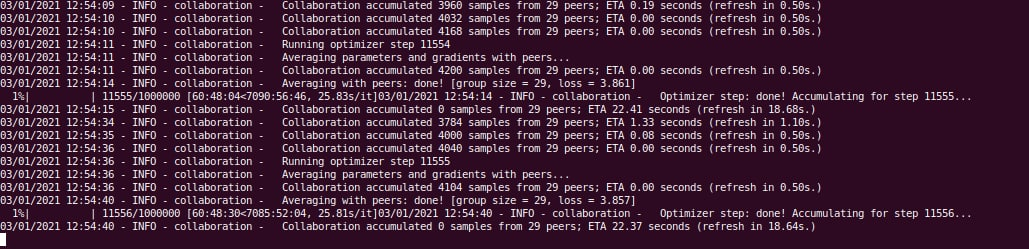